# Weather Forecast

# Objective
The primary goal of this analysis is to perform time series analysis and forescasting on wheather data.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

/opt/anaconda3/envs/py3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-22 20:08:03.408201: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset
This analysis uses the Daily Climate time series dataset from Kaggle (https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data), which comprises data from 1st January 2013 to 24th April 2017 in the city of Delhi, India.

It contains four parameters:

- meantemp
- humidity
- wind_speed
- meanpressure

In [2]:
# Load the train dataset (ensure the CSV file is in your working directory)
df = pd.read_csv("data/DailyDelhiClimateTrain.csv", parse_dates = ['date'], index_col = "date")

In [3]:
# Display basic information about the dataset
print("Dataset Information:")
print(df.info())

print("\nDescriptive Statistics:")
print(df.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB
None

Descriptive Statistics:
          meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.33

In [4]:
# Creating new features for EDA
df["year"] = df.index.year
df['month'] = df.index.month 
df['day'] = df.index.day

# Exploratory Data Analysis

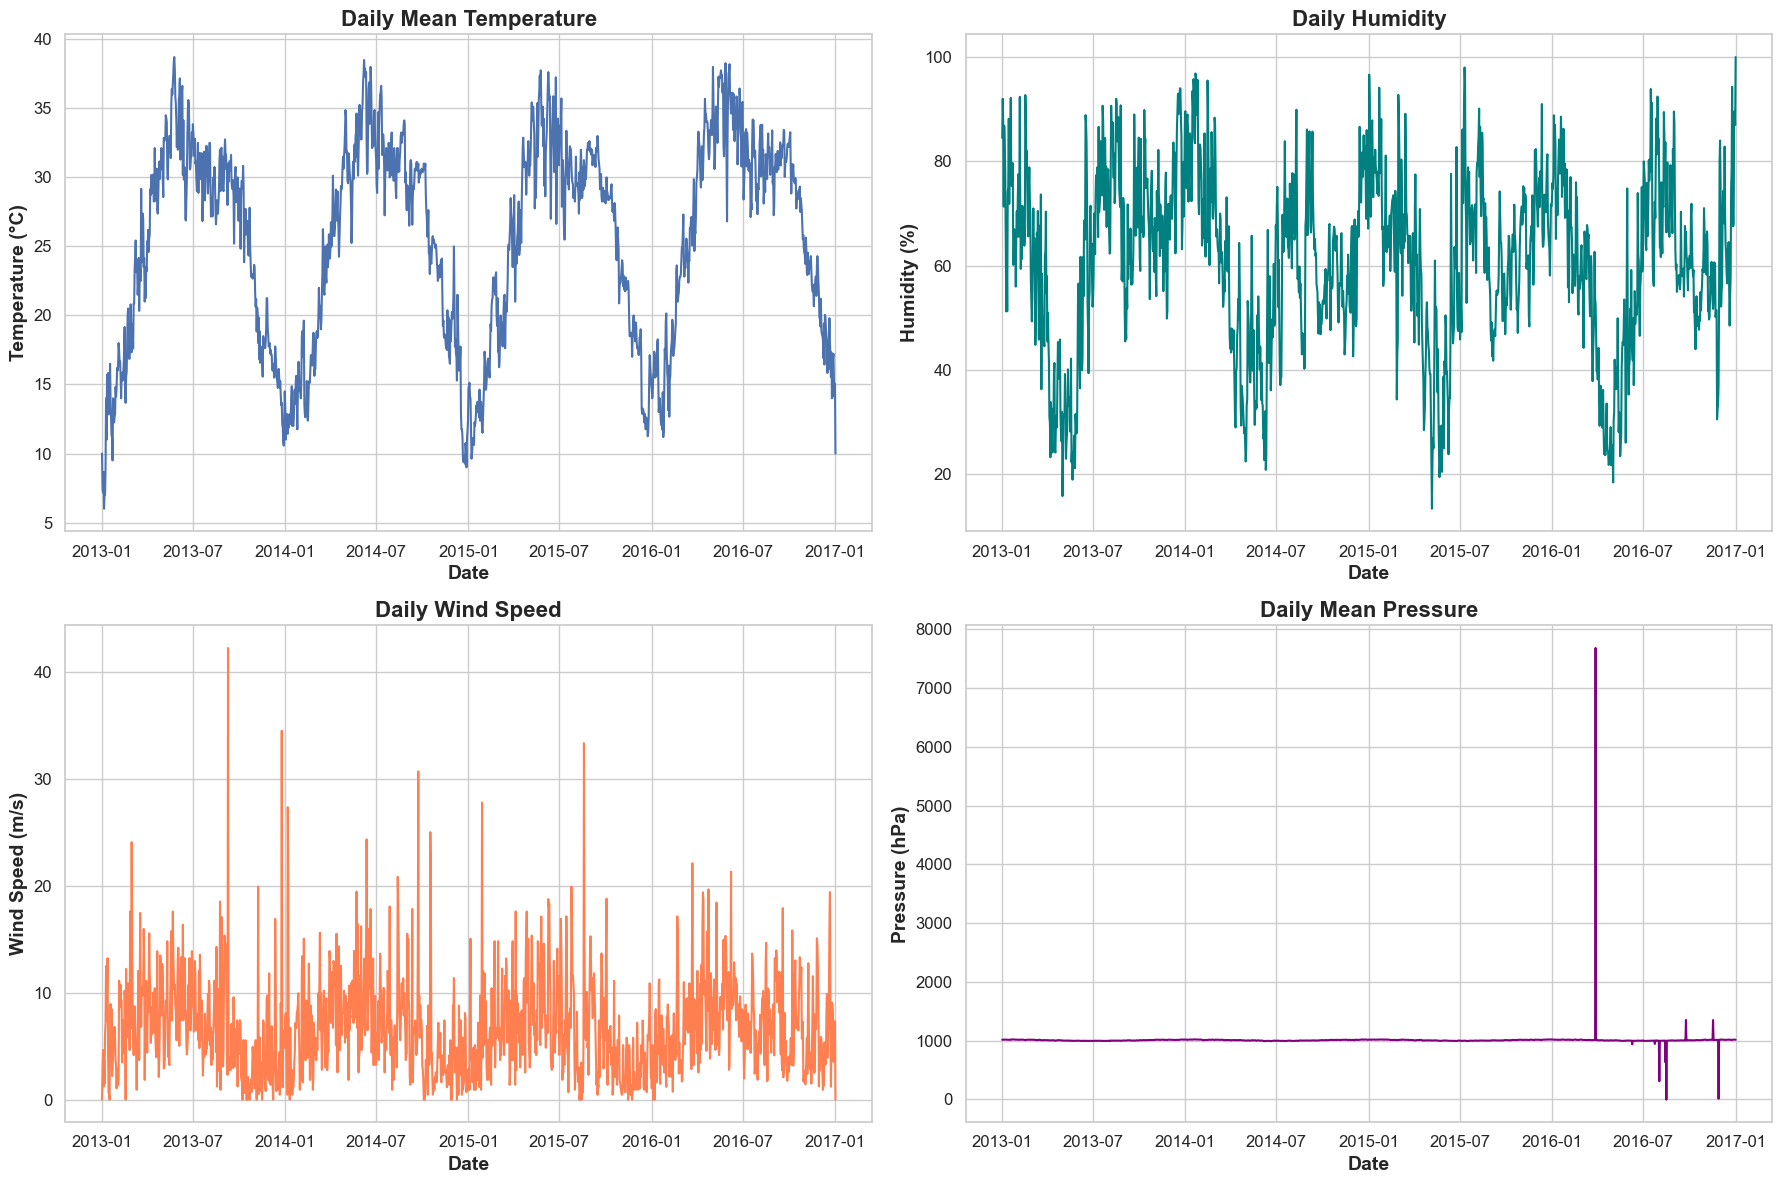

In [5]:
# Series per day

# Set the style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"]     = (15, 10)
plt.rcParams["axes.labelsize"]     = 14
plt.rcParams["axes.labelweight"]   = "bold"
plt.rcParams["xtick.labelsize"]    = 12
plt.rcParams["ytick.labelsize"]    = 12
plt.rcParams["axes.titlesize"]     = 16
plt.rcParams["axes.titleweight"]   = "bold"

# Prepare 2×2 axes
fig, axes = plt.subplots(2, 2, figsize = (18, 12))
axes = axes.flatten()

# Plot each series
# Plot 1: Mean Temperature
sns.lineplot(x = df.index, y = "meantemp", data = df, ax = axes[0])
axes[0].set_title("Daily Mean Temperature")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Temperature (°C)")

# Plot 2: Humidity
sns.lineplot(x = df.index, y = "humidity", data = df, ax = axes[1], color = 'teal')
axes[1].set_title("Daily Humidity")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Humidity (%)")

# Plot 3: Wind Speed
sns.lineplot(x = df.index, y = "wind_speed", data = df, ax = axes[2], color = 'coral')
axes[2].set_title("Daily Wind Speed")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Wind Speed (m/s)")

# Plot 4: Mean Pressure
sns.lineplot(x = df.index, y = "meanpressure", data = df, ax = axes[3], color = 'purple')
axes[3].set_title("Daily Mean Pressure")
axes[3].set_xlabel("Date")
axes[3].set_ylabel("Pressure (hPa)")

# Tidy up
plt.tight_layout()
plt.show()

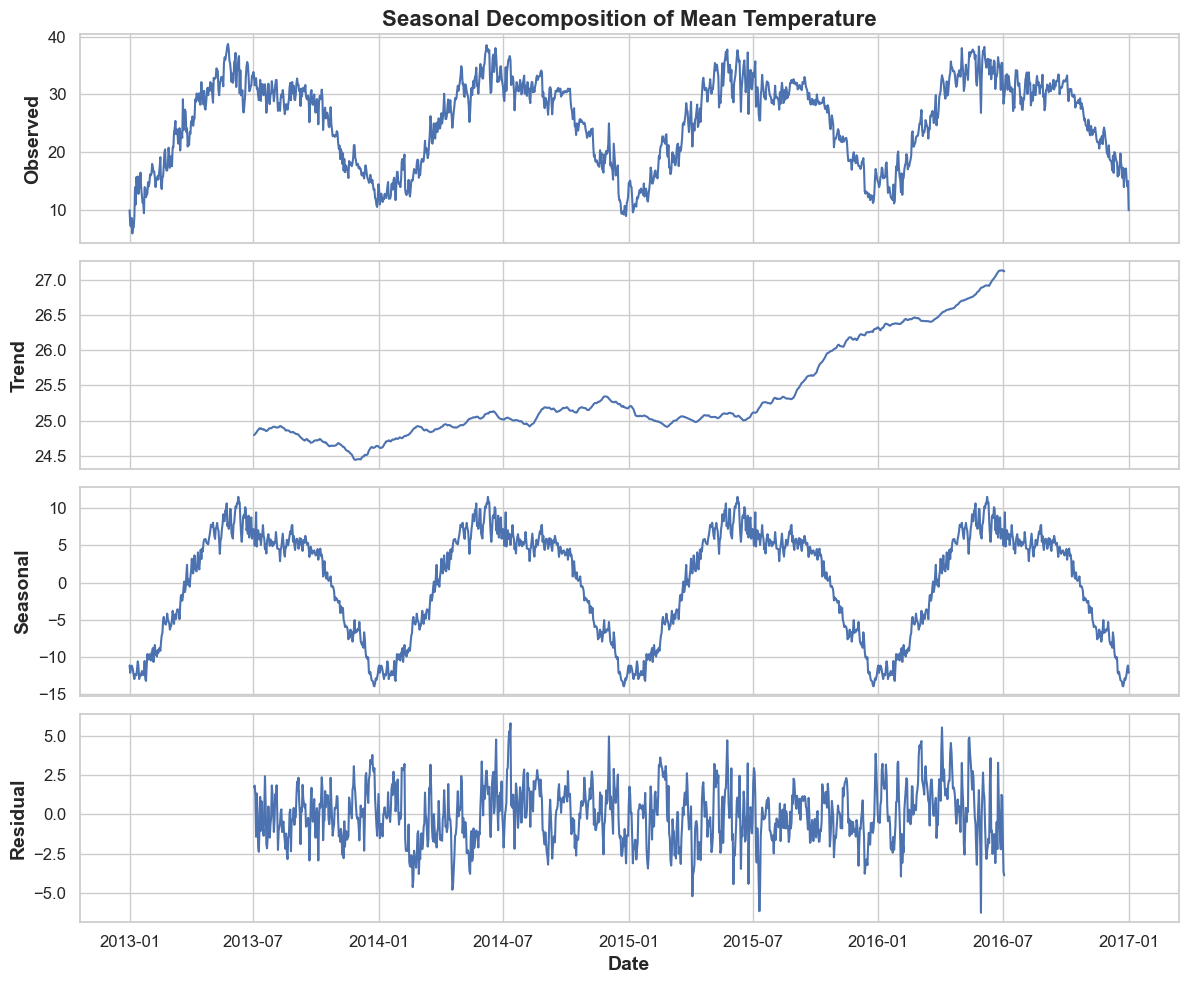

In [6]:
# Seasonal decompostion - Mean teamperature

# Choose series
series = df["meantemp"]

# Run the decomposition
decomp = seasonal_decompose(series, model = "additive", period = 365)

# Plot each component
fig, axes = plt.subplots(4, 1, figsize = (12, 10), sharex = True)

axes[0].plot(decomp.observed)
axes[0].set_ylabel("Observed")
axes[0].set_title("Seasonal Decomposition of Mean Temperature")

axes[1].plot(decomp.trend)
axes[1].set_ylabel("Trend")

axes[2].plot(decomp.seasonal)
axes[2].set_ylabel("Seasonal")

axes[3].plot(decomp.resid)
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("Date")

plt.tight_layout()
plt.show()

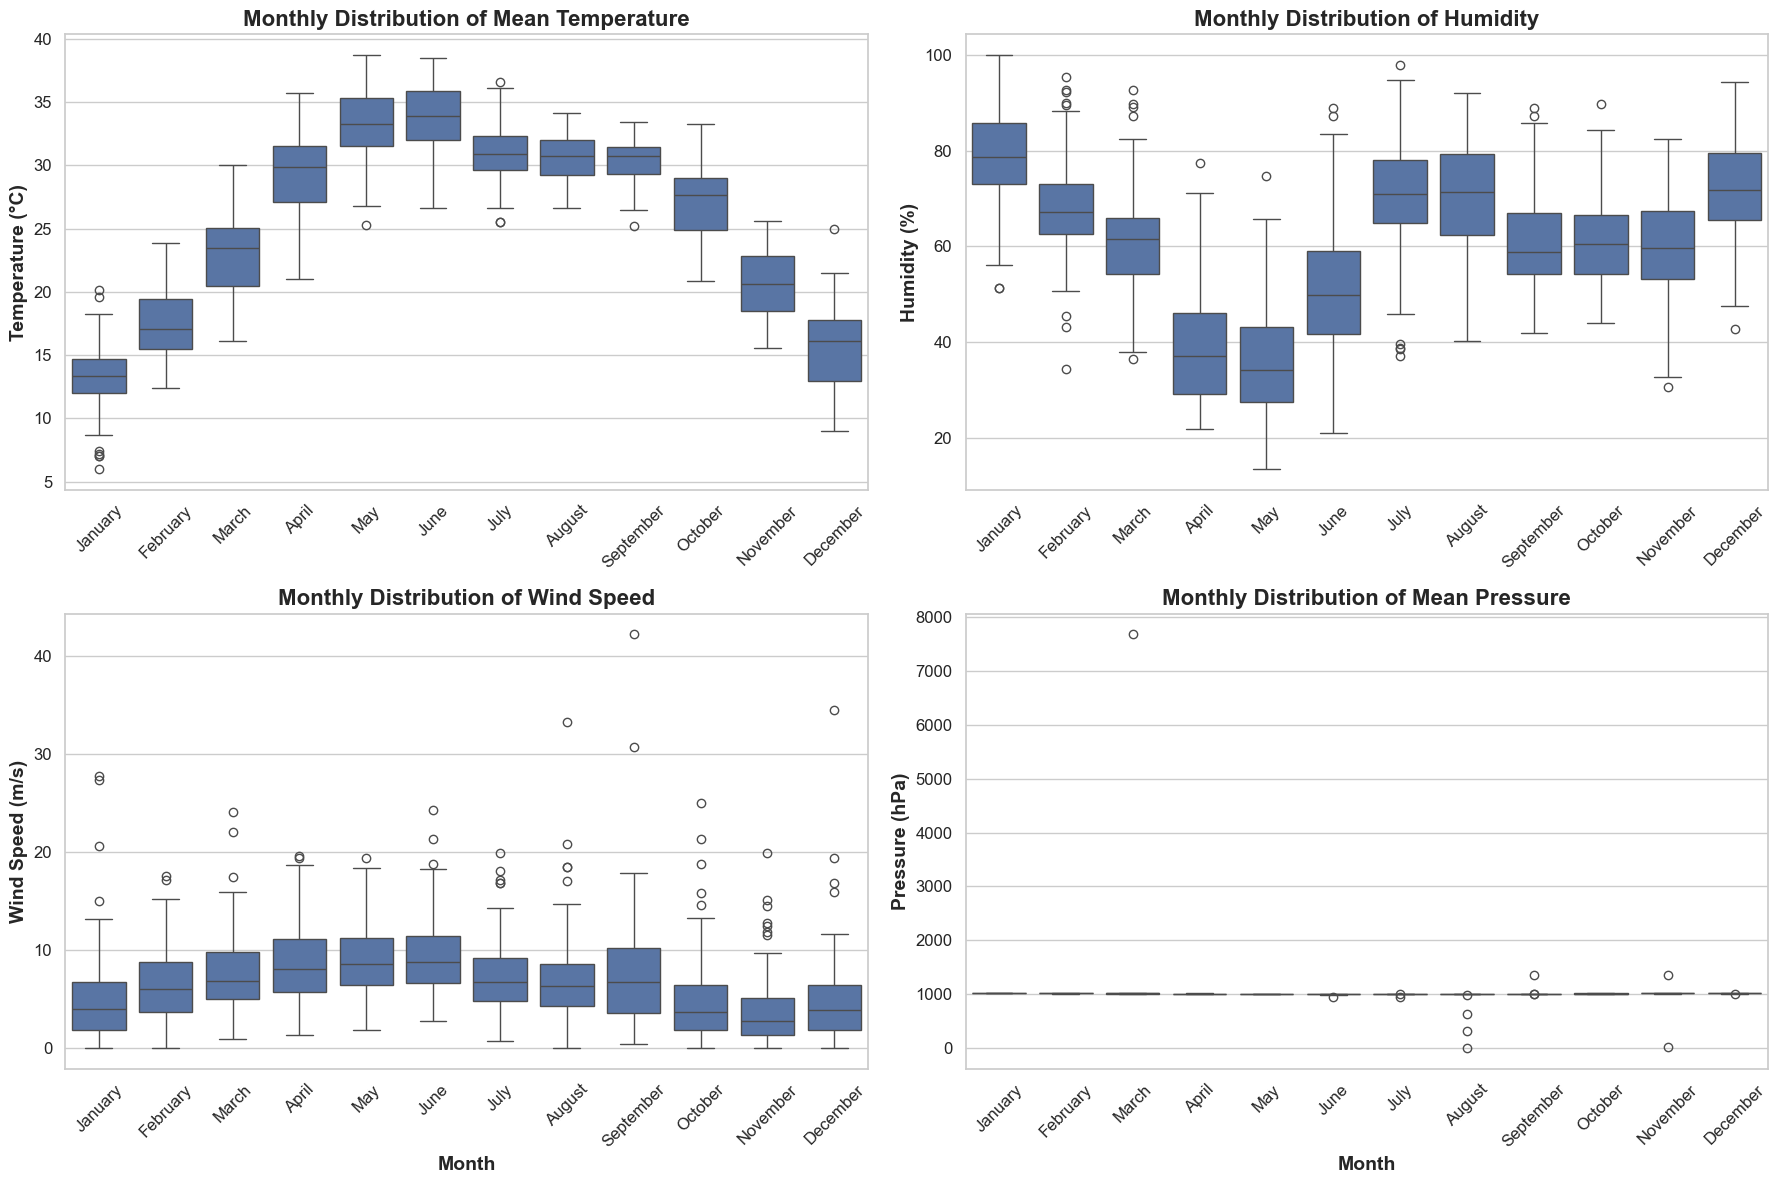

In [7]:
# Series per month

# Prepare month names
df["month_name"] = df.index.month.map(lambda m: calendar.month_name[m])
month_order = list(calendar.month_name)[1:]

# Styling
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"]   = (15, 10)
plt.rcParams["axes.labelsize"]   = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.labelsize"]  = 12
plt.rcParams["ytick.labelsize"]  = 12
plt.rcParams["axes.titlesize"]   = 16
plt.rcParams["axes.titleweight"] = "bold"

# Set up 2×2 grid
fig, axes = plt.subplots(2, 2, figsize = (18, 12))
axes = axes.flatten()

# Plot 1: Meantemp by month
sns.boxplot(x = "month_name", y = "meantemp", data = df, order = month_order, ax = axes[0])
axes[0].set_title("Monthly Distribution of Mean Temperature")
axes[0].set_xlabel("")
axes[0].set_ylabel("Temperature (°C)")
axes[0].tick_params(axis = 'x', rotation = 45)

# Plot 2: Humidity by month
sns.boxplot(x = "month_name", y = "humidity", data = df, order = month_order, ax = axes[1])
axes[1].set_title("Monthly Distribution of Humidity")
axes[1].set_xlabel("")
axes[1].set_ylabel("Humidity (%)")
axes[1].tick_params(axis = 'x', rotation = 45)

# Plot 3: Wind Speed by month
sns.boxplot(x = "month_name", y = "wind_speed", data = df, order = month_order, ax = axes[2])
axes[2].set_title("Monthly Distribution of Wind Speed")
axes[2].set_xlabel("Month")
axes[2].set_ylabel("Wind Speed (m/s)")
axes[2].tick_params(axis = 'x', rotation = 45)

# Plot 4: Mean Pressure by month
sns.boxplot(x = "month_name", y = "meanpressure", data = df, order = month_order, ax = axes[3])
axes[3].set_title("Monthly Distribution of Mean Pressure")
axes[3].set_xlabel("Month")
axes[3].set_ylabel("Pressure (hPa)")
axes[3].tick_params(axis = 'x', rotation = 45)

# Final layout
plt.tight_layout()
plt.show()

<Axes: >

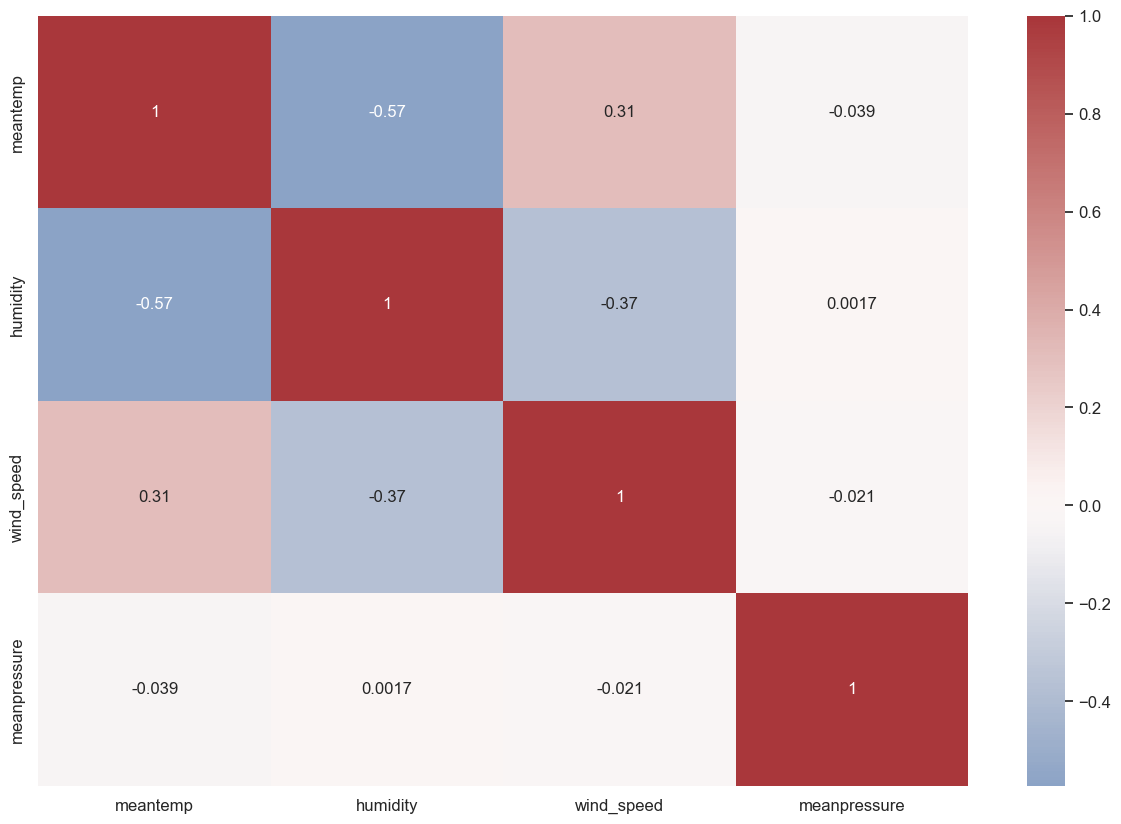

In [8]:
# Correlation matrix
corr = df[["meantemp", "humidity", "wind_speed", "meanpressure"]].corr()
sns.heatmap(corr, annot = True, cmap = "vlag", center = 0)

# Data Preprocessing

Before modeling, we verify the stationarity of each series combining visual checks (rolling statistics) with formal tests like ADF (Augmented Dickey-Fuller) and KPSS (Kwiatkowski-Phillips-Schmidt-Shin).

- Rolling statistics:

Stationary: Rolling mean and variance stay roughly constant.

Non‑stationary: Visible drifts or changing variance over time.

- Augmented Dickey–Fuller (ADF)

H₀: Unit root (series is non‑stationary)

Reject H₀ (p‑value < 0.05): Evidence of stationarity.

- KPSS

H₀: Series is stationary around a constant (or trend, depending on regression)

Reject H₀ (p‑value < 0.05): Evidence of non‑stationarity.

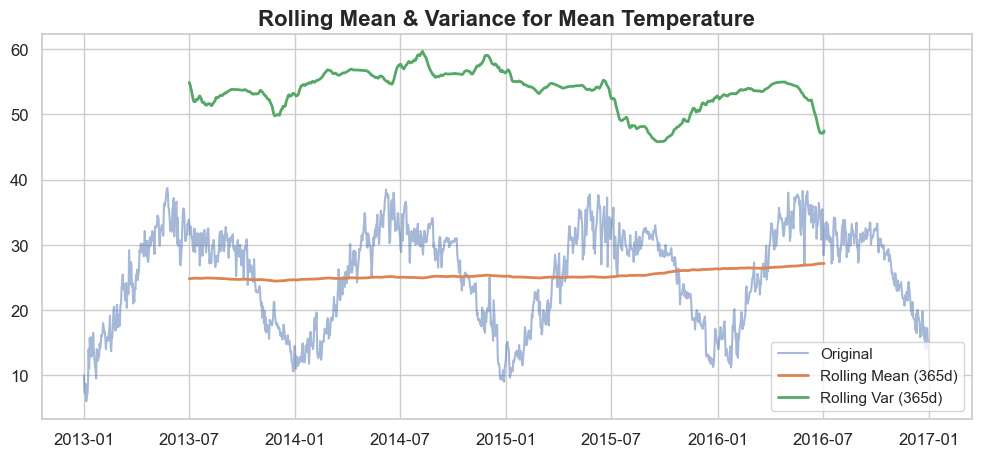


=== ADF Test ===
Statistic: -2.0211, p-value: 0.2774
  1% crit: -3.4349
  5% crit: -2.8635
  10% crit: -2.5678

=== KPSS Test ===
Statistic: 0.1879, p-value: 0.1000
  10% crit: 0.3470
  5% crit: 0.4630
  2.5% crit: 0.5740
  1% crit: 0.7390


/var/folders/ly/w484tkcx5c7c7ybl9rgjy09r000fsz/T/ipykernel_41570/2316499261.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series.dropna(), regression = "c", nlags = "auto")


In [9]:
# Check stationarity

# Extract series
series = df["meantemp"]

# Plot rolling mean and variance
rol_mean = series.rolling(window = 365, center = True).mean()
rol_var  = series.rolling(window = 365, center = True).var()

plt.figure(figsize = (12,5))
plt.plot(series, label = "Original", alpha = 0.5)
plt.plot(rol_mean, label = "Rolling Mean (365d)", linewidth = 2)
plt.plot(rol_var, label = "Rolling Var (365d)", linewidth = 2)
plt.legend()
plt.title("Rolling Mean & Variance for Mean Temperature")
plt.show()

# Define a function to test stationarity
def stationarity_tests(series):
    # ADF
    adf_stat, adf_p, _, _, adf_crit, _ = adfuller(series.dropna())
    # KPSS
    kpss_stat, kpss_p, _, kpss_crit = kpss(series.dropna(), regression = "c", nlags = "auto")
    print("\n=== ADF Test ===")
    print(f"Statistic: {adf_stat:.4f}, p-value: {adf_p:.4f}")
    for level, crit in adf_crit.items():
        print(f"  {level} crit: {crit:.4f}")
    print("\n=== KPSS Test ===")
    print(f"Statistic: {kpss_stat:.4f}, p-value: {kpss_p:.4f}")
    for level, crit in kpss_crit.items():
        print(f"  {level} crit: {crit:.4f}")

stationarity_tests(series)

When ADF says non‑stationary but KPSS says stationary, it’s a borderline case. Therefore we should difference the series and retest.

In [10]:
# First difference
df["temp_diff1"] = df["meantemp"].diff(1).dropna()

# Compare on differenced series
print(">> After 1st differencing:")
stationarity_tests(df["temp_diff1"])

>> After 1st differencing:

=== ADF Test ===
Statistic: -16.3787, p-value: 0.0000
  1% crit: -3.4349
  5% crit: -2.8635
  10% crit: -2.5678

=== KPSS Test ===
Statistic: 0.1896, p-value: 0.1000
  10% crit: 0.3470
  5% crit: 0.4630
  2.5% crit: 0.5740
  1% crit: 0.7390


/var/folders/ly/w484tkcx5c7c7ybl9rgjy09r000fsz/T/ipykernel_41570/2316499261.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series.dropna(), regression = "c", nlags = "auto")


The first‐difference series is now convincingly stationary.  No further seasonal differencing appears necessary.

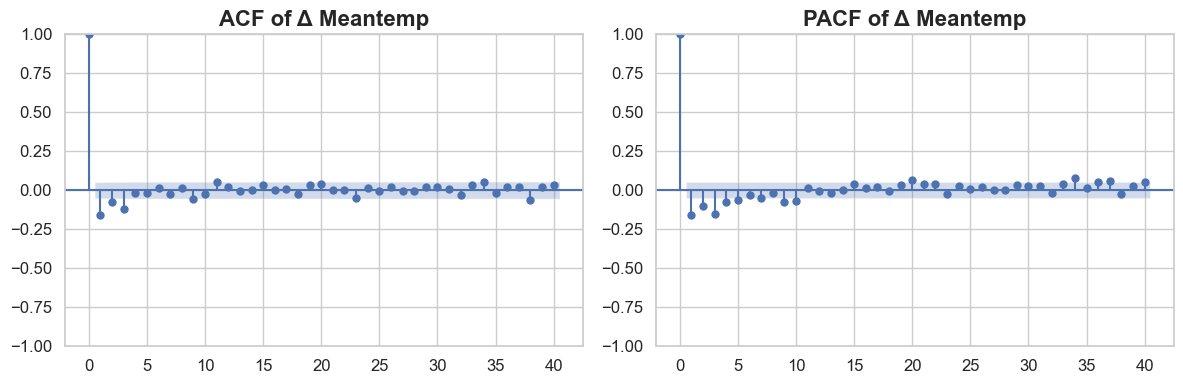

In [11]:
# ACF and PACF
series = df["temp_diff1"].dropna()

fig, ax = plt.subplots(1, 2, figsize = (12,4))
plot_acf(series, ax = ax[0], lags = 40)
ax[0].set_title("ACF of Δ Meantemp")
plot_pacf(series, ax = ax[1], lags = 40, method = "ywm")
ax[1].set_title("PACF of Δ Meantemp")
plt.tight_layout()
plt.show()

# Modeling

<b>SARIMAX Model with Exogenous Regressors<b>

In this section, we fit a Seasonal ARIMA (SARIMAX) model to our daily mean‐temperature series, incorporating humidity, wind speed, and mean pressure as exogenous predictors.  

- Exogenous variables: We extract the three climate covariates (`humidity`, `wind_speed`, `meanpressure`) to help explain day‑to‑day temperature fluctuations.  

- Order selection via `auto_arima`: Based on our stationarity tests, we fix the non‑seasonal difference to \(d=1\) (first differencing) and no seasonal differencing \(D=0\). We then let `auto_arima` search across small AR and MA orders \((p,q) \{0,1\}\) and seasonal \((P,Q) \{0,1\}\) with an annual seasonality of \(m=365\). This step automatically chooses the combination of parameters that minimizes the AIC.  

- Forecasting on the hold‐out set: We load the separate test set, pass its exogenous variables into `auto_exog.predict(...)`, and generate point forecasts plus 95% confidence intervals.  

- Evaluation: Finally, we compute the coefficient of determination (\(R^2\)) on the test period to quantify how well our SARIMAX model—with climate regressors—captures the variation in unseen temperature data. The resulting plot overlays the observed values, forecasted mean, and their confidence bands.  

In [ ]:
# SARIMAX model
X_train = df[["humidity", "wind_speed", "meanpressure"]]

# Let auto_arima pick best parameter
# Fixed d = 1 and D = 0 based on previous analysis
# Testing p, q up to 1 and seasonal P, Q up to 1, with annual seasonality (m = 365)
auto_exog = pm.auto_arima(
    y = df["meantemp"],
    exogenous    = X_train,
    start_p      = 0, start_q = 0,
    max_p        = 1, max_q   = 1,
    seasonal     = True, m    = 365,
    start_P      = 0, start_Q = 0,
    max_P        = 1, max_Q   = 1,
    d            = 1, # fixed differencing
    D            = 0,
    trace        = True,
    error_action = "ignore",
    suppress_warnings = True,
    stepwise     = True
)

print(auto_exog.summary())

/opt/anaconda3/envs/py3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[365] intercept   : AIC=5650.181, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[365] intercept   : AIC=inf, Time=341.62 sec


/opt/anaconda3/envs/py3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[365] intercept   : AIC=5603.522, Time=810.25 sec
 ARIMA(0,1,0)(0,0,0)[365]             : AIC=5648.181, Time=0.10 sec


/opt/anaconda3/envs/py3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[365] intercept   : AIC=5602.114, Time=0.14 sec


/opt/anaconda3/envs/py3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[365] intercept   : AIC=5603.491, Time=313.09 sec


/opt/anaconda3/envs/py3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [12]:
# Fit best model

# Prepare training data
df = pd.read_csv("data/DailyDelhiClimateTrain.csv", 
                 parse_dates = ["date"], index_col = "date")
X_train = df[["humidity", "wind_speed", "meanpressure"]]
y_train = df["meantemp"]

# Fit fixed-order SARIMAX via pmdarima
auto_exog = pm.ARIMA(
    order = (0, 1, 1),
    seasonal_order = (0, 0, 0, 365),
    exogenous = X_train,
    suppress_warnings = True
)
auto_exog.fit(y_train, exogenous = X_train)

print(auto_exog.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1462
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2798.057
Date:                Tue, 22 Apr 2025   AIC                           5602.114
Time:                        20:08:17   BIC                           5617.974
Sample:                    01-01-2013   HQIC                          5608.030
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.035      0.033      0.974      -0.067       0.069
ma.L1         -0.2193      0.021    -10.608      0.000      -0.260      -0.179
sigma2         2.6977      0.076     35.522      0.0

/opt/anaconda3/envs/py3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/opt/anaconda3/envs/py3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['exogenous']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/py3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Test set R² = -2.7758


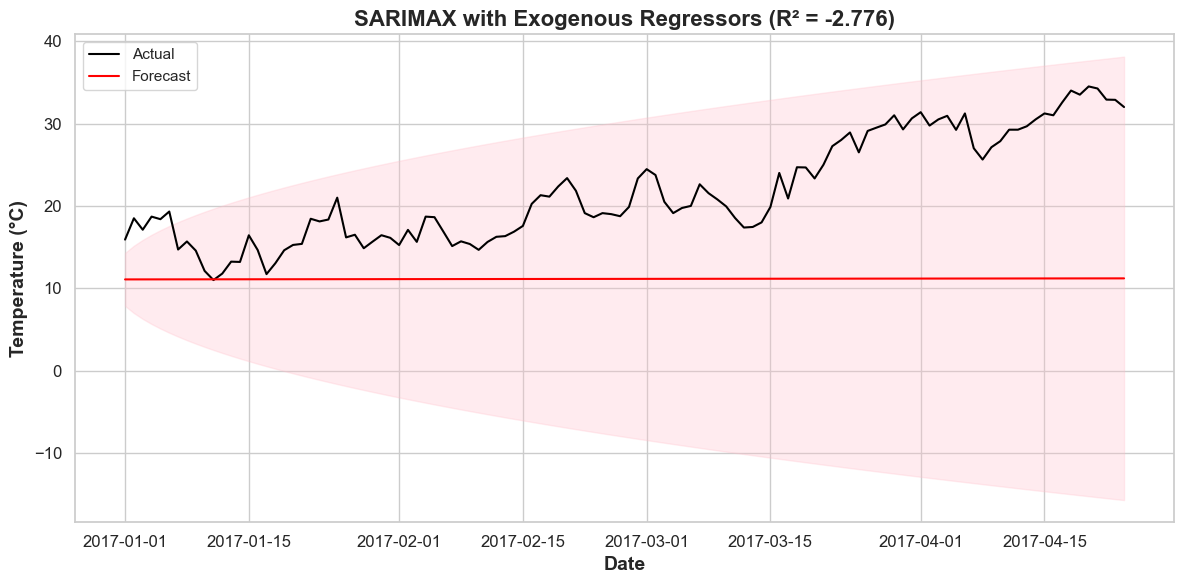

In [13]:
# Evaluation

# Load test data
df_test = pd.read_csv(
    "data/DailyDelhiClimateTest.csv",
    parse_dates = ['date'],
    index_col = 'date'
)
X_test = df_test[["humidity", "wind_speed", "meanpressure"]]

# Number of steps = len(df_test)
n_periods = len(df_test)

# Get point forecasts + CIs, passing in X_test
preds, conf_int = auto_exog.predict(
    n_periods = n_periods,
    exogenous = X_test,
    return_conf_int = True
)

# R^2
r2 = r2_score(df_test["meantemp"], preds)
print(f"Test set R² = {r2:.4f}")

# Build date index for forecast
fc_index = df_test.index

# Plot
plt.figure(figsize=(12,6))
plt.plot(df_test.index, df_test["meantemp"], label = "Actual", color = "black")
plt.plot(fc_index, preds, label = "Forecast", color = "red")
plt.fill_between(
    fc_index,
    conf_int[:,0],
    conf_int[:,1],
    color = "pink",
    alpha = 0.3
)
plt.title(f"SARIMAX with Exogenous Regressors (R² = {r2:.3f})", fontweight = "bold")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()

<b>Prophet Model with Exogenous Regressors<b>

In this section, we apply Facebook Prophet to forecast daily mean temperature, while incorporating humidity, wind speed, and mean pressure as additional predictors.

- Data preparation:

We convert our train/test DataFrames to Prophet’s expected format with columns `ds` (date) and `y` (target), and retain the three climate variables for use as regressors.

We concatenate train and test exogenous tables to easily merge future regressor values.

- Model configuration:

Enable yearly seasonality (built‑in), disable weekly/daily components, and increase the `changepoint_prior_scale` to allow more flexibility in trend changes.

Add a custom monthly seasonality (`period=30.5`, `fourier_order=5`) to capture intra‑year variation.

Register each climate variable (`humidity`, `wind_speed`, `meanpressure`) as an extra regressor so Prophet can learn their influence on temperature.

- Fitting and forecasting:

Fit the model on the training set only.

Use `make_future_dataframe(...)` to extend the date index through the test period, then merge and forward/back‑fill exogenous values to ensure no missing data.

Call `m.predict(...)` to generate in‑sample and out‑of‑sample forecasts.

- Evaluation and plotting:

Extract the final `len(df_test)` forecast rows, compute the test‑set \(R^2\) against the actual temperatures, and print the result.

Plot the observed vs. forecasted mean temperature with 95% confidence intervals to visually assess performance.

20:08:22 - cmdstanpy - INFO - Chain [1] start processing
20:08:22 - cmdstanpy - INFO - Chain [1] done processing


Test set R² = 0.6963


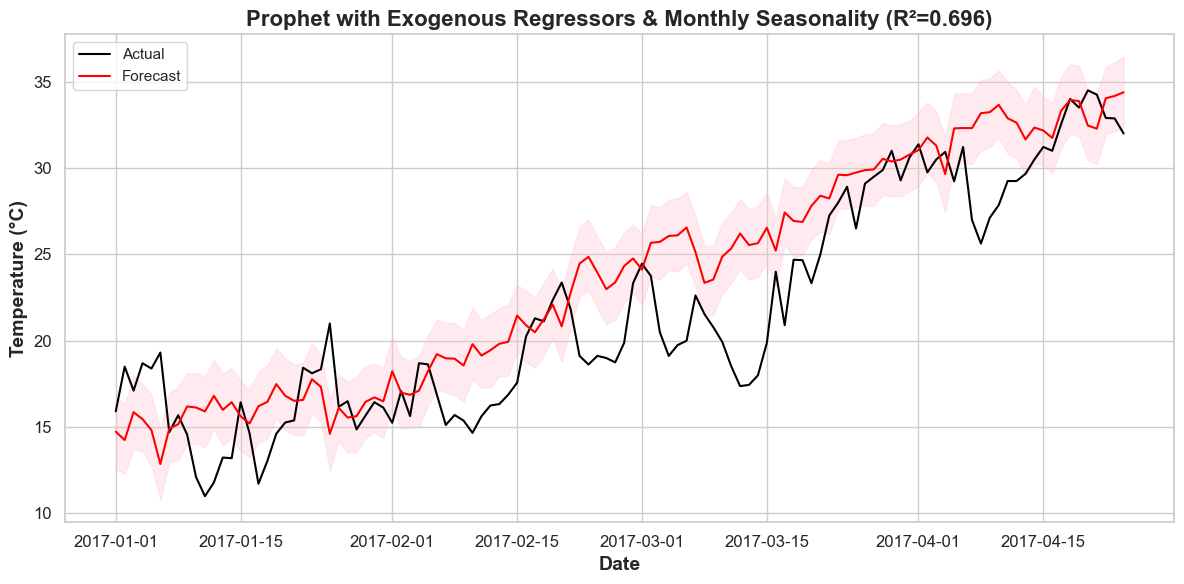

In [14]:
# Prophet

# Prepare helper
def prepare(df):
    df = df.reset_index().rename(columns = {"date":"ds", "meantemp":"y"})
    for col in ["humidity", "wind_speed", "meanpressure"]:
        df[col] = df[col].values
    return df

# Load train nad test
df_train = prepare(pd.read_csv(
    "data/DailyDelhiClimateTrain.csv",
    parse_dates = ["date"], index_col = "date"
))
df_test = prepare(pd.read_csv(
    "data/DailyDelhiClimateTest.csv",
    parse_dates = ["date"], index_col = "date"
))

# Full exogenous table
df_exog = pd.concat([df_train, df_test], axis = 0)[
    ["ds", "humidity", "wind_speed", "meanpressure"]
]

# Instantiate and configure Prophet
m = Prophet(
    yearly_seasonality = True,
    weekly_seasonality = False,
    daily_seasonality = False,
    changepoint_prior_scale = 0.1
)
m.add_seasonality(name = "monthly", period = 30.5, fourier_order = 5)
for reg in ["humidity", "wind_speed", "meanpressure"]:
    m.add_regressor(reg)

# Fit only on train
m.fit(df_train)

# Build future frame for train and test
future = m.make_future_dataframe(periods = len(df_test), freq = "D")

# Merge exogenous vars and fill any NaNs
future = future.merge(df_exog, on = "ds", how = "left")
future[["humidity", "wind_speed", "meanpressure"]] = (
    future[["humidity", "wind_speed", "meanpressure"]]
    .ffill()
    .bfill()
)

# Predict for all future dates
fc = m.predict(future)

# Grab exactly the last len(df_test) rows as our test forecasts
fc_test = fc.iloc[-len(df_test):].copy().reset_index(drop = True)
df_test_sub = df_test.reset_index(drop = True)

# Compute R^2
r2 = r2_score(df_test_sub["y"], fc_test["yhat"])
print(f"Test set R² = {r2:.4f}")

# Plot actual vs forecast
plt.figure(figsize = (12,6))
plt.plot(df_test_sub["ds"], df_test_sub["y"], color = "black", label = "Actual")
plt.plot(df_test_sub["ds"], fc_test["yhat"], color = "red", label = "Forecast")
plt.fill_between(
    df_test_sub["ds"],
    fc_test["yhat_lower"],
    fc_test["yhat_upper"],
    color = "pink", alpha = 0.3
)
plt.title(f"Prophet with Exogenous Regressors & Monthly Seasonality (R²={r2:.3f})",
          fontweight = "bold")
plt.xlabel("Date"); plt.ylabel("Temperature (°C)")
plt.legend(); plt.tight_layout(); plt.show()

<b>Multivariate LSTM Forecasting<b>

In this section, we build and train a deep‐learning model (LSTM) that uses the past 30 days of all four climate variables (mean temperature, humidity, wind speed, and mean pressure) to predict the next day’s mean temperature.

- Data loading and train/test split:

We read in the train and test CSVs, then extract the four features into NumPy arrays.

- Scaling:

All features are normalized to the \[0,1\] range using a `MinMaxScaler` to ensure stable LSTM training.

- Sequence construction:

Using a look‑back window of 30 days, we build input sequences `X` of shape `(samples, 30, 4)` and target vectors `y` of the next day’s temperature.

- Model architecture:

Two stacked LSTM layers (64 then 32 units) with `tanh` activations.

Dropout layers (20%) to guard against overfitting.

Final dense layer to output a single temperature value.

- Training:

The model is compiled with the Adam optimizer and MSE loss, then trained for 50 epochs with a 15% validation split.

- Forecasting and inverse scaling:

We predict on the test sequences, then invert the MinMax scaling to recover actual temperature values.

- Evaluation:

Compute the test‑set \(R^2\) to quantify performance.

- Visualization:

Overlay the actual vs. predicted mean temperature on the test period to assess how well the LSTM captures daily variation.

2025-04-22 20:08:24.295137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-22 20:08:24.296961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-22 20:08:24.298025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2025-04-22 20:08:24.510730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-22 20:08:24.512457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-22 20:08:24.513947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 - 5s - loss: 0.0548 - val_loss: 0.0047 - 5s/epoch - 131ms/step
Epoch 2/50
39/39 - 1s - loss: 0.0127 - val_loss: 0.0051 - 648ms/epoch - 17ms/step
Epoch 3/50
39/39 - 1s - loss: 0.0127 - val_loss: 0.0048 - 644ms/epoch - 17ms/step
Epoch 4/50
39/39 - 1s - loss: 0.0100 - val_loss: 0.0046 - 638ms/epoch - 16ms/step
Epoch 5/50
39/39 - 1s - loss: 0.0099 - val_loss: 0.0041 - 643ms/epoch - 16ms/step
Epoch 6/50
39/39 - 1s - loss: 0.0087 - val_loss: 0.0058 - 639ms/epoch - 16ms/step
Epoch 7/50
39/39 - 1s - loss: 0.0101 - val_loss: 0.0057 - 666ms/epoch - 17ms/step
Epoch 8/50
39/39 - 1s - loss: 0.0090 - val_loss: 0.0057 - 643ms/epoch - 16ms/step
Epoch 9/50
39/39 - 1s - loss: 0.0081 - val_loss: 0.0052 - 637ms/epoch - 16ms/step
Epoch 10/50
39/39 - 1s - loss: 0.0087 - val_loss: 0.0043 - 640ms/epoch - 16ms/step
Epoch 11/50
39/39 - 1s - loss: 0.0081 - val_loss: 0.0059 - 638ms/epoch - 16ms/step
Epoch 12/50
39/39 - 1s - loss: 0.0098 - val_loss: 0.0045 - 633ms/epoch - 16ms/step
Epoch 13/50
39/39 - 1s - l

2025-04-22 20:09:02.802140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-22 20:09:02.804175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-22 20:09:02.805323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 7ms/step
Test set (R² = 0.8811)


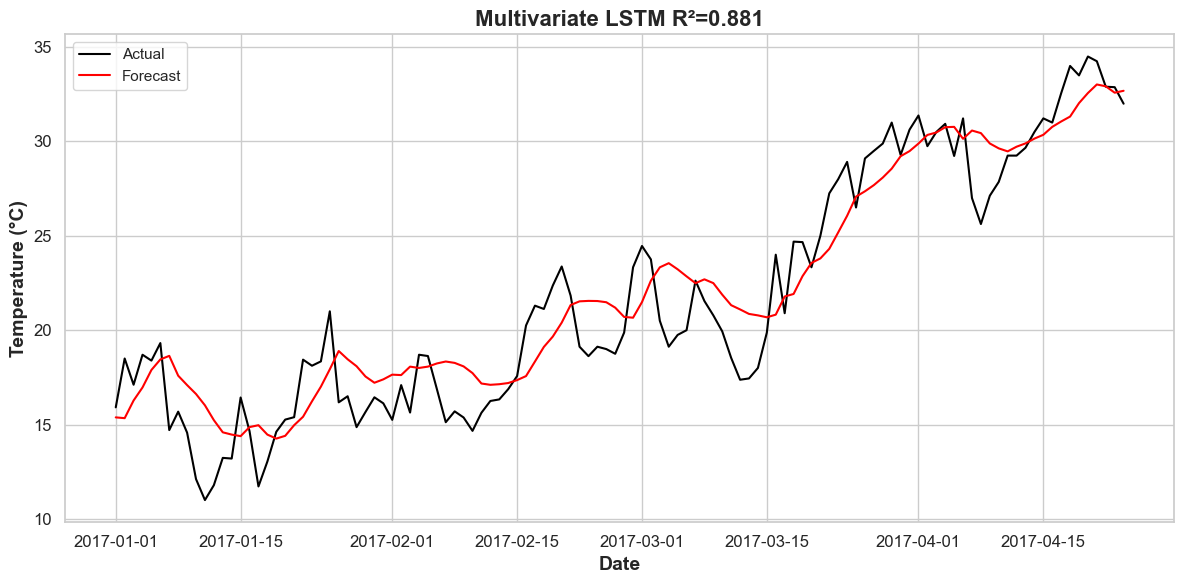

In [15]:
# LSTM

# Load train and test
df_train = pd.read_csv("data/DailyDelhiClimateTrain.csv", 
                       parse_dates = ["date"], index_col = "date")
df_test = pd.read_csv("data/DailyDelhiClimateTest.csv",  
                       parse_dates = ["date"], index_col = "date")

# Select features (all four) and values
features = ["meantemp", "humidity", "wind_speed", "meanpressure"]
train_vals = df_train[features].values # shape (n_train, 4)
test_vals = df_test[features].values # shape (n_test, 4)

# Scale each feature to [0,1]
scaler = MinMaxScaler(feature_range = (0,1))
train_scaled = scaler.fit_transform(train_vals)
test_scaled = scaler.transform(test_vals)

# Build sequences
def create_sequences(data, look_back = 30):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i]) # shape (look_back, n_features)
        y.append(data[i, 0]) # we predict meantemp, which is col 0
    return np.array(X), np.array(y)

look_back = 30
X_train, y_train = create_sequences(train_scaled, look_back)

# For test, seed with last look_back of train + test data
combined = np.vstack([train_scaled[-look_back:], test_scaled])
X_test, y_test = create_sequences(combined, look_back)

# Reshape (samples, timesteps, features)
n_features = train_scaled.shape[1] # 4
X_train = X_train.reshape((-1, look_back, n_features))
X_test = X_test.reshape((-1, look_back, n_features))

# Build a multivariate LSTM
model = Sequential([
    LSTM(64, activation = "tanh", input_shape = (look_back, n_features), return_sequences = True),
    Dropout(0.2),
    LSTM(32, activation = "tanh"),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer = "adam", loss = "mse")

# Train
history = model.fit(
    X_train, y_train,
    epochs = 50,
    batch_size = 32,
    validation_split = 0.15,
    verbose = 2
)

# Forecast on test
y_pred_scaled = model.predict(X_test)

# Invert scaling for y only
#    we need to invert the first column (meantemp) back
#    so stack preds with the other (dummy) columns from test_scaled
dummy_cols = np.zeros((len(y_pred_scaled), n_features-1))
inv_stack = np.hstack([y_pred_scaled, dummy_cols])
y_pred = scaler.inverse_transform(inv_stack)[:, 0]
y_test_true = scaler.inverse_transform(np.hstack([y_test.reshape(-1,1), dummy_cols]))[:, 0]

# Compute R^2
r2 = r2_score(y_test_true, y_pred)
print(f"Test set (R² = {r2:.4f})")

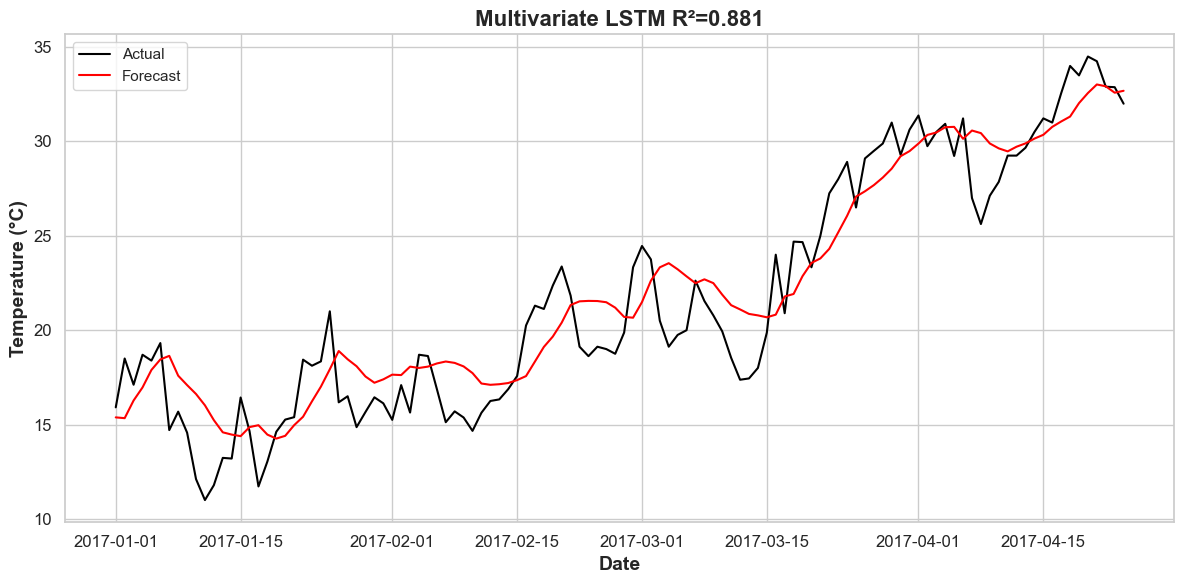

In [16]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(df_test.index, y_test_true, label = "Actual", color = "black")
plt.plot(df_test.index, y_pred, label = "Forecast", color = "red")
plt.title(f"Multivariate LSTM R²={r2:.3f}",
          fontweight = "bold")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()

# Conclusion



The LSTM delivered the strongest performance, demonstrating its ability to learn complex, nonlinear relationships in the data. Based on these results, the LSTM approach should be prioritized, while further refinements to feature engineering could help close the remaining gap in forecast accuracy.